In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
from Neural_Lib_Flo import *

In [3]:
# Set the device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Set the root directory
root_dir_sensorium = '/project/data/static21067-10-18-GrayImageNet-94c6ff995dac583098847cfecd43e7b6/data'
images_path = '/project/subiculum/data/images_uint8.npy'
v1_responses_path = '/project/subiculum/data/V1_Data.mat'


In [4]:
pretrain_train_loader, pretrain_val_loader, pretrain_test_loader = dataloader_from_npy(root_dir_sensorium, device)

In [5]:
print(f'shape in dataloader {next(iter(pretrain_train_loader))[0].shape}')

# Define early stopping criteria
early_stopping_patience = 5
early_stopping_counter = 0
best_val_loss = float('-inf')

# Initialize the model for pretraining
pretrain_model = ConvModel(
    layers=10, 
    input_kern=11,
    hidden_kern=5, 
    hidden_channels=64, 
    output_dim=8372,  # Output dimension for the pretraining dataset
    std_scale=0.5
)

pretrain_model = pretrain_model.to(device)
poisson_loss = PoissonLoss() # use different loss
gamma = 1e-2
loss_fn = lambda outputs, targets: poisson_loss(outputs, targets) + gamma * pretrain_model.regularizer()

optimizer = torch.optim.Adam(pretrain_model.parameters(), lr=1e-3)

# Define the learning rate schedule
lr_scheduler = ReduceLROnPlateau(optimizer, mode='max', factor=0.1, patience=3, verbose=True)

shape in dataloader torch.Size([32, 1, 72, 128])


/usr/local/lib/python3.8/dist-packages/neuralpredictors/measures/modules.py:78: UserWarning: Poissonloss is averaged per batch. It's recommended to use `sum` instead
  warnings.warn("Poissonloss is averaged per batch. It's recommended to use `sum` instead")


In [6]:
# Define the number of epochs
epochs = 100

for epoch in range(epochs):
    # Training loop
    loss = my_train_epoch(pretrain_model, pretrain_train_loader, optimizer, loss_fn, device)
    
    # Validation loop
    with torch.no_grad():
        val_corrs = get_correlations(pretrain_model, pretrain_val_loader, device)
    validation_correlation = val_corrs.mean()
    
    # Update learning rate schedule
    lr_scheduler.step(validation_correlation)
    
    # Print training and validation losses
    print(f'Epoch [{epoch+1}/{epochs}], validation correlation: {validation_correlation:.4f}, trainloss: {loss:.4f}')
    
    # Check for early stopping
    if validation_correlation > best_val_loss:
        best_val_loss = validation_correlation
        early_stopping_counter = 0
    else:
        early_stopping_counter += 1
        if early_stopping_counter >= early_stopping_patience:
            print('Early stopping triggered!')
            break

print('Freezing core.')

for param in pretrain_model.core.parameters():
    param.requires_grad = False

Epoch [1/5], validation correlation: 0.0511, trainloss: 0.8186
Epoch [2/5], validation correlation: 0.0520, trainloss: 0.6081
Epoch [3/5], validation correlation: 0.0669, trainloss: 0.5652
Epoch [4/5], validation correlation: 0.0779, trainloss: 0.5480
Epoch [5/5], validation correlation: 0.0842, trainloss: 0.5371
Freezing core.


In [7]:

pretrain_model.readout = GaussianReadout(13, 64, spatial_scale=8, std_scale=0.8).to(device)

In [8]:

train_loader, val_loader, test_loader = dataloader_from_mat_w_pad(images_path, v1_responses_path, 75, 125, 32)
print(f'shape in dataloader {next(iter(train_loader))[0].shape}')

shape in dataloader torch.Size([32, 1, 72, 128])


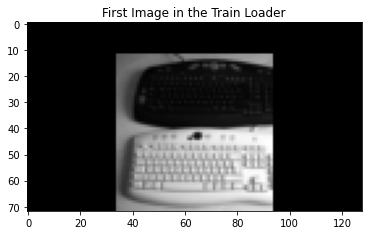

In [9]:
# Plot the first image in the train_loader
import matplotlib.pyplot as plt
def plot_first_image(train_loader):
    for images, _ in train_loader:
        first_image = images[0].cpu().numpy().squeeze()
        plt.imshow(first_image, cmap='gray')
        plt.title("First Image in the Train Loader")
        plt.show()
        break

plot_first_image(train_loader)

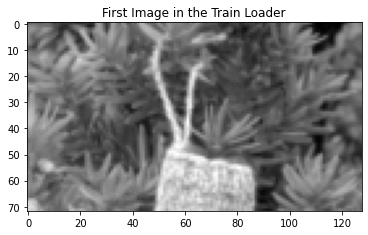

In [10]:
plot_first_image(pretrain_train_loader)

In [11]:
# Train the readout
train_readout(pretrain_model, train_loader, val_loader, num_epochs=100, optimizer=optimizer, loss_fn=loss_fn, device=device)

In [ ]:
# Evaluate the model
evaluate_model(pretrain_model, test_loader, device)

Test Loss: 0.9463
Test Correlation: 0.0007


(array([[1.0315471 , 0.86805886, 0.991892  , ..., 0.8416923 , 1.009727  ,
         0.86805886],
        [1.0425045 , 0.8680588 , 0.99189174, ..., 0.84169185, 1.0097234 ,
         0.8680588 ],
        [1.0613132 , 0.86805415, 0.99189115, ..., 0.8416926 , 1.0097241 ,
         0.86805415],
        ...,
        [1.0586183 , 0.8680573 , 0.9918908 , ..., 0.841693  , 1.009728  ,
         0.8680573 ],
        [1.020396  , 0.8680577 , 0.9918925 , ..., 0.8416926 , 1.0097249 ,
         0.8680577 ],
        [1.0498383 , 0.86805844, 0.99189305, ..., 0.8416923 , 1.0097269 ,
         0.86805844]], dtype=float32),
 array([[0., 0., 0., ..., 1., 0., 0.],
        [0., 0., 0., ..., 1., 0., 0.],
        [0., 1., 0., ..., 3., 0., 1.],
        ...,
        [0., 0., 0., ..., 1., 0., 1.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]], dtype=float32))